In [1]:
# %% Imports
from visualization import *
unique_id = "34fec7e871b14fdcac5db6dfb944be16"

save_ext = 'seed'
suffix = None

In [2]:
config = recover_config(unique_id, save_ext=save_ext, suffix=suffix)
vocab_size = config["vocab_size"]
length = config["seq_length"]
sparsity_index = config["sparsity_index"]
ffn_dim = config["ffn_dim"]
assert config["save_weights"], f"Weights were not saved for ID {unique_id}."

save_dir, _ = get_paths(save_ext, suffix=suffix)
save_dir = save_dir / unique_id
weights = pickle.load(open(save_dir / "weights.pkl", "rb"))
losses = pickle.load(open(save_dir / "losses.pkl", "rb"))
test_losses = pickle.load(open(save_dir / "test_losses.pkl", "rb"))
accs = pickle.load(open(save_dir / "accs.pkl", "rb"))
test_accs = pickle.load(open(save_dir / "test_accs.pkl", "rb"))

DEVICE = "cpu"

# modules

config = ModelConfig(
    vocab_size=config["nb_emb"],
    emb_dim=config["emb_dim"],
    seq_length=config["seq_length"],
    ffn_dim=config["ffn_dim"],
    ffn_bias=config["ffn_bias"],
)
model = Model(config)
model.eval()
model.to(DEVICE)
norm = RMSNorm()

# variables

kwargs = {
    "DEVICE": DEVICE,
    "vocab_size": vocab_size,
    "sparsity_index": sparsity_index,
    "length": length,
    "ffn_dim": ffn_dim,
    "losses": losses,
    "test_losses": test_losses,
    "accs": accs,
    "test_accs": test_accs,
    "text_fontsize": 8,
    "title_fontsize": 12,
    "pos_marker": "o",
    "neg_marker": "s",
    "third_marker": "^",
}


# plot configurations

plot_functions = {
    "show_token_emb": show_token_emb,
    "show_pos_emb": show_pos_emb,
    "show_emb": show_emb,
    "show_norm_emb": show_norm_emb,
    "show_attn": show_attn,
    "show_value": show_value,
    "show_seq_emb": show_seq_emb,
    "show_level_line": show_level_line,
    "show_norm_input": show_norm_input,
    "show_mlp_receptors": show_mlp_receptors,
    "show_mlp_emitters": show_mlp_emitters,
    "show_mlp_output": show_mlp_output,
    "show_output_level_lines": show_output_level_lines,
    "show_output": show_output,
    "show_loss": show_loss,
    "show_acc": show_acc,
}

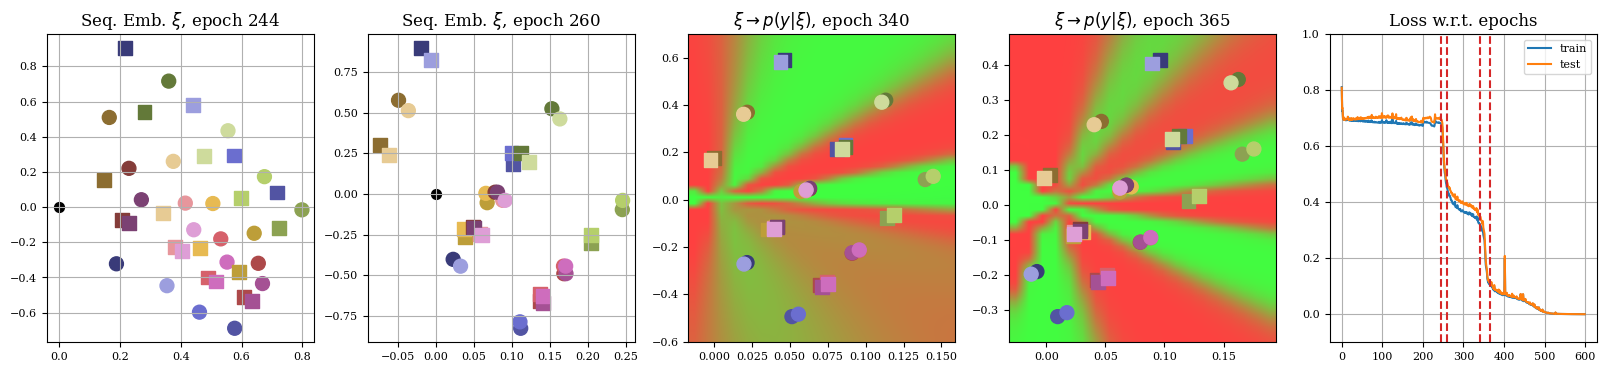

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))


for i, frame in enumerate([244, 260, 340, 365, 600]):
    model.load_state_dict(weights[frame])
    variables = ComputationCache(
        {
            "weights": weights[frame],
            "model": model,
            "norm": norm,
            "frame": frame,
        }
        | kwargs
    )
    if i in [0, 1]:
        # show seq_emb
        show_seq_emb(axes[i], variables)
        axes[i].set_title(rf"Seq. Emb. $\xi$, epoch {frame}", fontsize=12)
    elif i in [2, 3]:
        # show level lines
        show_level_line(axes[i], variables)
        axes[i].set_title(rf"$\xi\to p(y|\xi)$, epoch {frame}", fontsize=12)
    else:
        # show loss
        show_loss(axes[i], variables)
        axes[i].set_yscale("linear")
        axes[i].grid()
        for tmp in [244, 260, 340, 365]:
            axes[i].plot([tmp, tmp], [-.1, 1], color="C3", linestyle="--")
        axes[i].set_ylim(-.1, 1)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].set_title("Loss w.r.t. epochs", fontsize=12)

fig.savefig("dynamics.pdf", bbox_inches="tight")

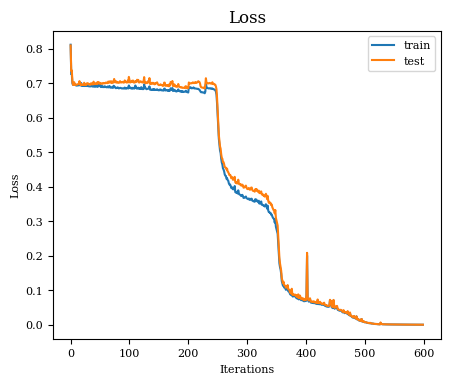

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
show_loss(ax, variables)
ax.set_yscale("linear")